# Degree distribution

## Import statements

In [ ]:
import time
import networkx as nx
import numpy as np

from typing import List
import dfg_rating.viz.jupyter_widgets as DFGWidgets
from dfg_rating.model.network.base_network import BaseNetwork
from dfg_rating.model.network.random_network import ConfigurationModelNetwork
from dfg_rating.model.rating.controlled_trend_rating import ControlledTrendRating, ControlledRandomFunction
from dfg_rating.model.rating.elo_rating import ELORating


from dfg_rating.model.evaluators.accuracy import RankProbabilityScore, Likelihood
from dfg_rating.model.forecast.true_forecast import LogFunctionForecast

from dfg_rating.viz.tables import get_evaluation

## Data Generation

In [ ]:
in_degree = 120
out_degree = 120
initial_variance = 0
maximum_variance = 150
variance_step = 2

### Example network

In [ ]:
example_network = ConfigurationModelNetwork(
    teams=200,
    days_between_rounds=3,
    true_rating=ControlledTrendRating(
        starting_point=ControlledRandomFunction(distribution='normal', loc=1000, scale=100),
        delta=ControlledRandomFunction(distribution='normal', loc=0, scale=3),
        trend=ControlledRandomFunction(distribution='normal', loc=0, scale=20/365),
        season_delta=ControlledRandomFunction(distribution='normal', loc=0, scale=10)
    ),
    expected_home_matches=in_degree,
    expected_away_matches=out_degree,
    variance_home_matches=initial_variance + 50,
    variance_away_matches=initial_variance + 50
)

In [ ]:
len(example_network.data.edges())

In [ ]:
app = DFGWidgets.NetworkExplorer(network=example_network)

In [ ]:
example_network.density(True)

In [ ]:
app.run('inline', port=8002)

### Range of networks

In [ ]:
networks_list: List[BaseNetwork] = []

In [ ]:
variance_range = range(initial_variance, maximum_variance + 1, variance_step)
for variance in variance_range:
    start_time = time.time()
    networks_list.append(
        ConfigurationModelNetwork(
            teams=50,
            days_between_rounds=3,
            true_forecast=LogFunctionForecast(
                outcomes=['home', 'draw', 'away'],
                coefficients = [-0.9,0.3],
                beta_parameter=0.006
            ),
            true_rating=ControlledTrendRating(
                starting_point=ControlledRandomFunction(distribution='normal', loc=1000, scale=100),
                delta=ControlledRandomFunction(distribution='normal', loc=0, scale=3),
                trend=ControlledRandomFunction(distribution='normal', loc=0, scale=20/365),
                season_delta=ControlledRandomFunction(distribution='normal', loc=0, scale=10)
            ),
            expected_home_matches=in_degree,
            expected_away_matches=out_degree,
            variance_home_matches=variance,
            variance_away_matches=variance
        )
    )
    print(np.var([t[1] for t in networks_list[-1].degree(True)]))
    print(f"Added network with Degree variance of {variance} in {time.time() -  start_time} seconds.")

### Evaluation metrics

In [ ]:
minimum_k = 15
maximum_k = 65
k_options = [v for v in range(minimum_k, maximum_k + 1, 2)]

In [ ]:
for k_parameter in k_options:
    start_time = time.time()
    rating_name = f"elo_rating_{k_parameter}"
    forecast_name = f"elo_forecast_{k_parameter}"
    elo = ELORating(trained=True, param_k=k_parameter)
    rps = RankProbabilityScore(
        outcomes=['home', 'draw', 'away'],
        forecast_name=forecast_name
    )
    l = Likelihood(
        outcomes=['home', 'draw', 'away'],
        forecast_name=forecast_name  
    )
    for i, n in enumerate(networks_list):
        print(i, end='\r')
        n.add_rating(
        rating=elo, 
        rating_name=rating_name
        )
        n.add_forecast(
            LogFunctionForecast(
                outcomes=['home', 'draw', 'away'],
                coefficients=[-0.9, 0.3],
                beta_parameter=0.006
            ),
            forecast_name,
            rating_name
        )
        n.add_evaluation(rps, f"{rating_name}_RPS")
        n.add_evaluation(l, f"{rating_name}_likelihood")
    
    print(f"Added ELO Rating with k = {k_parameter} in {time.time() - start_time} seconds.")

## Results

In [ ]:
experiment_results = []

In [ ]:
for k_parameter in k_options:
    start_time = time.time()
    for i, n in enumerate(networks_list):
        experiment_results += get_evaluation(n, k_parameter, evaluators=['RPS'], **{"Variance": variance_range[i], "Density": n.density(True)})

## Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import pearsonr
import statsmodels.api as sm
from tqdm import tqdm

pio.templates.default = "plotly_white"

pd.options.display.float_format = '{:.4f}'.format

pd.set_option("display.max_columns", None)

### New results

In [ ]:
experiment_df = pd.DataFrame(experiment_results)
today = datetime.datetime.today().strftime("%A, %d. %B %Y %I:%M%p")
experiment_df.to_csv(os.path.join("Degree_results", f"{today}.csv"))

### Read past results

In [2]:
experiment_df = pd.read_csv(os.path.join("..", "..", "scripts","Final_results", "final_degree.csv"))

In [3]:
experiment_df["Home_elo_rating"] = experiment_df["Home_elo_ratin"].fillna(0) + experiment_df["Home_elo_rating"].fillna(0)
experiment_df["Away_elo_rating"] = experiment_df["Away_elo_ratin"].fillna(0) + experiment_df["Away_elo_rating"].fillna(0)

In [4]:
experiment_df["spread"] = experiment_df["Variance"]/240
experiment_df[["spread", "Variance"]]

spread  Variance
0         0.0000         0
1         0.0000         0
2         0.0000         0
3         0.0000         0
4         0.0000         0
...          ...       ...
19507273  1.0000       240
19507274  1.0000       240
19507275  1.0000       240
19507276  1.0000       240
19507277  1.0000       240

[19507278 rows x 2 columns]

In [5]:
test = experiment_df.groupby(["Variance", "Round", "Day"]).agg({"HomeRating": ["mean", "std"]})
test.loc[156]

HomeRating         
                   mean      std
Round Day                       
0     1        989.6840  98.9724
1     453     1013.5282  90.8338
2     905     1006.6907  99.8899
3     1357    1010.0522  93.9580
4     1809     995.9510  92.5170
...                 ...      ...
393   177637  1013.1752 107.4257
394   178089  1004.3004 118.3680
395   178541  1011.6548 101.9748
396   178993  1017.7245 110.0824
397   179445  1009.0152 115.6511

[398 rows x 2 columns]

experiment_dfootstrap functionsexperiment_df

In [6]:
def bootstrap(data, n_iter=9999):
    n = len(data)
    dist_bootstrapped = np.full(shape=n_iter, fill_value=np.nan)
    for i in tqdm(range(n_iter)):
        resample = np.random.choice(data, size=n, replace=True)
        dist_bootstrapped[i] = np.mean(resample)
    quantiles = np.quantile(a=dist_bootstrapped, q=[0.005, 0.995])
    return quantiles[0], quantiles[1]

## Analysis

Raw data from the simulation is at match level. For every match we have each elo_rating K, forecast, RPS and differences

In [7]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'summary_with_mean',
        "height": 400,
        "width": 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=14,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=1,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    font_dict = dict(
        family='Times New Roman',
        size=14,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

In [8]:
dfg=experiment_df[experiment_df.ELO_Rating_K == 15].groupby('spread').count().reset_index()
dfg["mean"] = dfg["HomeTeam"].mean()
dfg

spread  Unnamed: 0  HomeTeam  AwayTeam  Season  Round    Day  Result  \
0   0.0000       24046     24046     24046   24046  24046  24046   24046   
1   0.0250       23876     23876     23876   23876  23876  23876   23876   
2   0.0500       23880     23880     23880   23880  23880  23880   23880   
3   0.0750       23832     23832     23832   23832  23832  23832   23832   
4   0.1000       23492     23492     23492   23492  23492  23492   23492   
5   0.1250       23746     23746     23746   23746  23746  23746   23746   
6   0.1500       23906     23906     23906   23906  23906  23906   23906   
7   0.1750       23950     23950     23950   23950  23950  23950   23950   
8   0.2000       23312     23312     23312   23312  23312  23312   23312   
9   0.2250       24176     24176     24176   24176  24176  24176   24176   
10  0.2500       23952     23952     23952   23952  23952  23952   23952   
11  0.2750       22910     22910     22910   22910  22910  22910   22910   
12  0.3000       23186     23186     23186   23186  23186  23186   23186   
13  0.3250       23214     23214     23214   23214  23214  23214   23214   
14  0.3500       23320     23320     23320   23320  23320  23320   23320   
15  0.3750       23796     23796     23796   23796  23796  23796   23796   
16  0.4000       20894     20894     20894   20894  20894  20894   20894   
17  0.4250       22066     22066     22066   22066  22066  22066   22066   
18  0.4500       21018     21018     21018   21018  21018  21018   21018   
19  0.4750       18640     18640     18640   18640  18640  18640   18640   
20  0.5000       19686     19686     19686   19686  19686  19686   19686   
21  0.5250       20522     20522     20522   20522  20522  20522   20522   
22  0.5500       18466     18466     18466   18466  18466  18466   18466   
23  0.5750       20300     20300     20300   20300  20300  20300   20300   
24  0.6000       22464     22464     22464   22464  22464  22464   22464   
25  0.6250       21648     21648     21648   21648  21648  21648   21648   
26  0.6500       22334     22334     22334   22334  22334  22334   22334   
27  0.6750       22584     22584     22584   22584  22584  22584   22584   
28  0.7000       22268     22268     22268   22268  22268  22268   22268   
29  0.7250       22324     22324     22324   22324  22324  22324   22324   
30  0.7500       20550     20550     20550   20550  20550  20550   20550   
31  0.7750       23098     23098     23098   23098  23098  23098   23098   
32  0.8000       21972     21972     21972   21972  21972  21972   21972   
33  0.8250       22694     22694     22694   22694  22694  22694   22694   
34  0.8500       22734     22734     22734   22734  22734  22734   22734   
35  0.8750       23916     23916     23916   23916  23916  23916   23916   
36  0.9000       25120     25120     25120   25120  25120  25120   25120   
37  0.9250       22658     22658     22658   22658  22658  22658   22658   
38  0.9500       23226     23226     23226   23226  23226  23226   23226   
39  0.9750       23150     23150     23150   23150  23150  23150   23150   
40  1.0000       25992     25992     25992   25992  25992  25992   25992   

    TrueForecast  CalculatedForecast  ELO_Rating_K  Variance  Density  \
0          24046               24046         24046     24046    24046   
1          23876               23876         23876     23876    23876   
2          23880               23880         23880     23880    23880   
3          23832               23832         23832     23832    23832   
4          23492               23492         23492     23492    23492   
5          23746               23746         23746     23746    23746   
6          23906               23906         23906     23906    23906   
7          23950               23950         23950     23950    23950   
8          23312               23312         23312     23312    23312   
9          24176               24176         24176     24176    24176   
10      

#### Sample sizes charts: Total and total with density anotated

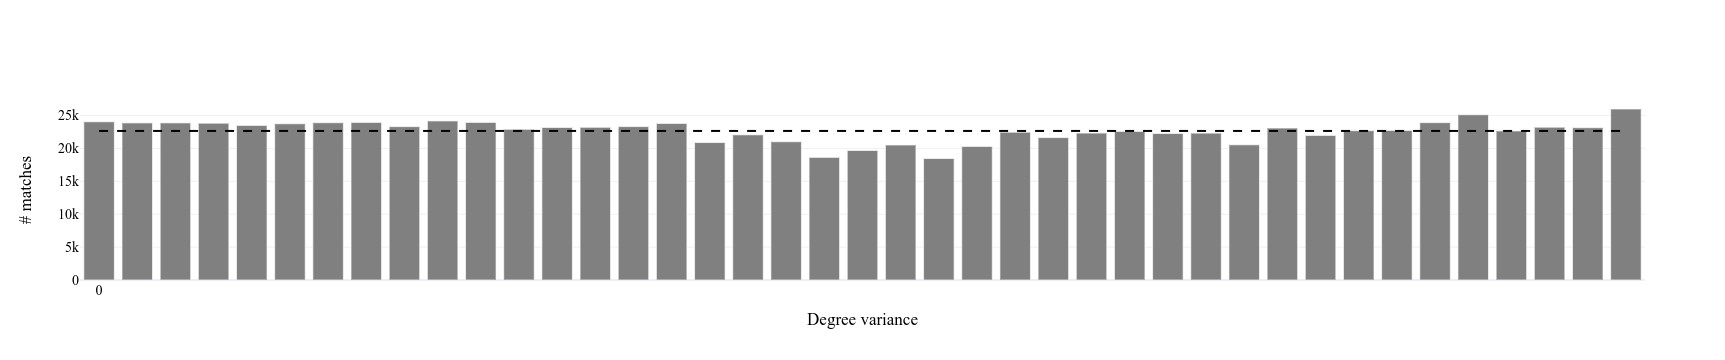

In [9]:
fig = go.Figure()
# plot structure
fig.add_trace(go.Bar(
    x=dfg['spread'],
    y=dfg['HomeTeam'],
    marker_color='gray'
))

fig.add_trace(go.Scatter(
    x=dfg["spread"],
    y=dfg["mean"],
    mode="lines",
    line = dict(color='black', dash='dash')
))
# plot
return_fig_settings(fig, 'Degree variance', '# matches')
fig.update_xaxes(tickmode='linear', tick0=0, dtick=20)
fig.update_layout(showlegend=False)
fig.show(config=config)

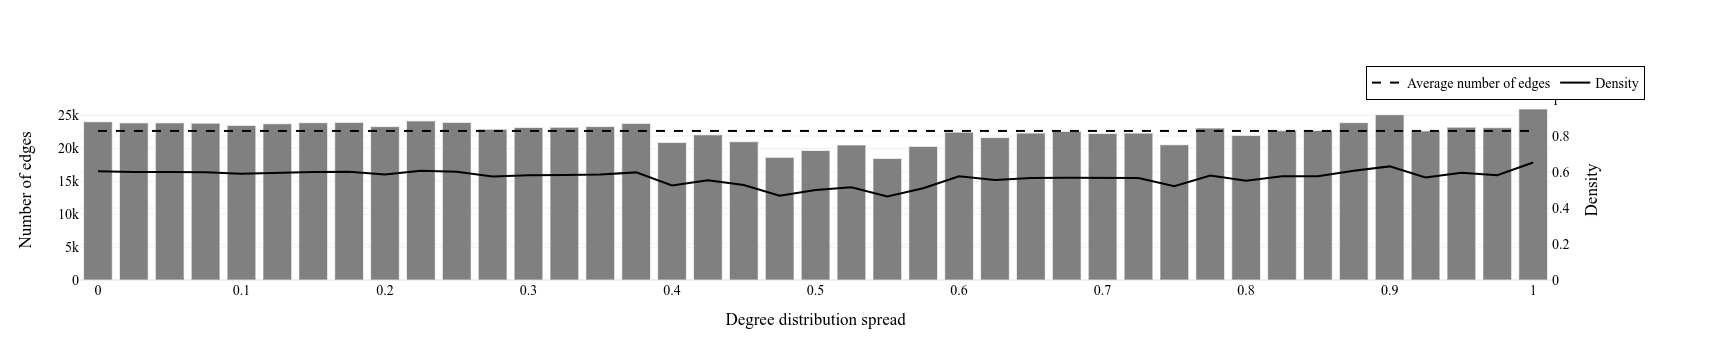

In [10]:
dfg_density=experiment_df[experiment_df.ELO_Rating_K == 15].groupby('spread', as_index=False).agg({"Density": "mean"})
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
# plot structure
fig.add_trace(go.Bar(
    x=dfg['spread'],
    y=dfg['HomeTeam'],
    marker_color='gray',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=dfg["spread"],
    y=dfg["mean"],
    mode="lines",
    line = dict(color='black', dash='dash'),
    name="Average number of edges",
    showlegend=True
))
fig.add_trace(go.Scatter(
    x=dfg_density["spread"],
    y=dfg_density["Density"],
    mode="lines",
    line = dict(color='black'),
    name="Density",
    showlegend=True
),secondary_y=True)
# plot
return_fig_settings(fig, 'Degree distribution spread', 'Number of edges')
fig.update_xaxes(tickmode='linear', tick0=0, dtick=0.1)

fig.update_yaxes(title_text="Density", range=[0.0, 1.0], secondary_y=True)
fig.update_layout(showlegend=True)
fig.show(config=config)

#### Team ratings differences

Comparing how True and ELO rating rate the matchup and also how far the elo rating is from the true values.

In [11]:
experiment_df['TrueDiff'] = experiment_df['HomeRating'] - experiment_df['AwayRating']
experiment_df['ELODiff'] = experiment_df['Home_elo_rating'] - experiment_df['Away_elo_rating']
experiment_df['RatingError'] = abs(experiment_df['TrueDiff'].abs() - experiment_df['ELODiff'].abs())

In [12]:
experiment_df['HomeDiff'] = abs(experiment_df['HomeRating'] - experiment_df['Home_elo_rating'])
experiment_df['AwayDiff'] = abs(experiment_df['AwayRating'] - experiment_df['Away_elo_rating'])
experiment_df['TotalDiff'] = experiment_df['HomeDiff'].abs() + experiment_df['AwayDiff'].abs()
experiment_df["TeamDiff"] = (experiment_df["HomeDiff"].abs() + experiment_df["AwayDiff"].abs()) / 2

Team diff is the average of AwayDiff and HomeDiff

In [13]:
experiment_df[["HomeDiff", "AwayDiff", "TeamDiff"]].head()

HomeDiff  AwayDiff  TeamDiff
0   37.0758  122.6313   79.8535
1   58.6020  126.1874   92.3947
2   65.6466    3.3947   34.5206
3  125.5169  238.2241  181.8705
4  126.4549   11.3368   68.8959

#### Adding degree information

In [14]:
aux_df = experiment_df[experiment_df["ELO_Rating_K"] == 15]
home_degree = aux_df[['Variance', 'HomeTeam']].value_counts().to_frame('counts').to_dict()["counts"]
away_degree = aux_df[['Variance', 'AwayTeam']].value_counts().to_frame('counts').to_dict()["counts"]
for k,v in away_degree.items():
    home_degree[k] = home_degree.get(k, 0) + v

In [15]:
experiment_df["HomeDegree"] = [home_degree.get((v, t), 0) for v,t in tuple(zip(experiment_df["Variance"], experiment_df["HomeTeam"]))]
experiment_df["AwayDegree"] = [home_degree.get((v, t), 0) for v,t in tuple(zip(experiment_df["Variance"], experiment_df["AwayTeam"]))]

For every variance, we categorise the degrees in 10 grups

In [16]:
experiment_df["HomeDegreeGroup"] = experiment_df.groupby(['Variance'])['HomeDegree'].transform(lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=["low_degree", "medium_group", "high_degree"]))
experiment_df["AwayDegreeGroup"] = experiment_df.groupby(['Variance'])['AwayDegree'].transform(lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=["low_degree", "medium_group", "high_degree"]))

In [17]:
experiment_df[experiment_df.Variance == 234].groupby("AwayDegreeGroup").agg({"AwayDegree": "mean"})

AwayDegree
AwayDegreeGroup            
low_degree         108.4038
medium_group       289.1738
high_degree        338.8913

In [18]:
experiment_df["TotalDegree"] = experiment_df["HomeDegree"] + experiment_df["AwayDegree"]
experiment_df["TotalDegreeGroup"] = experiment_df.groupby(['Variance'])['TotalDegree'].transform(lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=["low_degree", "medium_group", "high_degree"]))

In [19]:
#experiment_df[(experiment_df["Variance"] == 240)][["HomeTeam", "AwayTeam", "HomeDegree", "AwayDegree"]].describe()
#experiment_df.groupby("Variance").agg({"HomeDegree": ["mean", "min", "max"], "AwayDegree": ["mean", "min", "max"]})
experiment_df[["HomeDegree", "HomeDegreeGroup", "AwayDegree", "AwayDegreeGroup", "TotalDegree", "TotalDegreeGroup"]]

HomeDegree HomeDegreeGroup  AwayDegree AwayDegreeGroup  TotalDegree  \
0                238    medium_group         274     high_degree          512   
1                228    medium_group         254    medium_group          482   
2                246    medium_group         250    medium_group          496   
3                230    medium_group         234    medium_group          464   
4                244    medium_group         244    medium_group          488   
...              ...             ...         ...             ...          ...   
19507273         146      low_degree         342    medium_group          488   
19507274         354     high_degree         334    medium_group          688   
19507275         326    medium_group         330    medium_group          656   
19507276         360     high_degree         328    medium_group          688   
19507277         258    medium_group         336    medium_group          594   

         TotalDegreeGroup  
0             high_degree  
1            medium_group  
2            medium_group  
3            medium_group  
4            medium_group  
...                   ...  
19507273     medium_group  
19507274      high_degree  
19507275     medium_group  
19507276      high_degree  
19507277     medium_group  

[19507278 rows x 6 columns]

### Optimal K for density values

#### Split of data

The 10 first rounds are used as a rating initialisation. After that a third of the rounds is used as in_sample evaluation

In [20]:
init_dict = {}
split_dict = {}
for index, item in experiment_df.groupby("Variance").agg({'Round': 'max'})['Round'].items():
    split_dict[index] = int(item * 0.5)
    init_dict[index] = int(item * 0.2)
experiment_df['Init_Rounds'] = experiment_df['Variance'].map(init_dict)
experiment_df['Split_Rounds'] = experiment_df['Variance'].map(split_dict)

In [21]:
in_sample = experiment_df[(experiment_df.Round > experiment_df.Init_Rounds) & (experiment_df.Round <=  experiment_df.Split_Rounds)]
in_sample[in_sample.Variance == 0]

Unnamed: 0  HomeTeam  AwayTeam  Season  Round    Day Result  \
4867          4867       180         0       0     80  36161   home   
4868          4868        37         2       0     80  36161   away   
4869          4869        41       102       0     80  36161   away   
4870          4870        36         3       0     80  36161   home   
4871          4871        35         4       0     80  36161   home   
...            ...       ...       ...     ...    ...    ...    ...   
492938      492938       193        95       0    198  89497   draw   
492939      492939       194        96       0    198  89497   away   
492940      492940       195        97       0    198  89497   draw   
492941      492941       197        99       0    198  89497   home   
492942      492942       198       199       0    198  89497   home   

          TrueForecast CalculatedForecast  ELO_Rating_K  Variance  Density  \
4867    0.38-0.29-0.33     0.42-0.29-0.29             5         0   0.6042   
4868    0.11-0.18-0.70     0.33-0.29-0.38             5         0   0.6042   
4869    0.47-0.28-0.25     0.43-0.29-0.29             5         0   0.6042   
4870    0.44-0.28-0.28     0.43-0.28-0.29             5         0   0.6042   
4871    0.74-0.16-0.09     0.49-0.27-0.24             5         0   0.6042   
...                ...                ...           ...       ...      ...   
492938  0.40-0.29-0.31     0.25-0.28-0.47            45         0   0.6042   
492939  0.13-0.21-0.66     0.15-0.22-0.64            45         0   0.6042   
492940  0.38-0.29-0.33     0.37-0.29-0.34            45         0   0.6042   
492941  0.85-0.10-0.05     0.89-0.08-0.04            45         0   0.6042   
492942  0.25-0.28-0.47     0.22-0.26-0.51            45         0   0.6042   

        RealDegree  RealVariance    RPS  Likelihood  ForecastError  \
4867      240.4600       14.1756 0.2110     -0.8666         0.0016   
4868      240.4600       14.1756 0.2477     -0.9710         0.0758   
4869      240.4600       14.1756 0.3451     -1.2465         0.0016   
4870      240.4600       14.1756 0.2038     -0.8459         0.0001   
4871      240.4600       14.1756 0.1575     -0.7102         0.0415   
...            ...           ...    ...         ...            ...   
492938    240.4600       14.1756 0.1437     -1.2891         0.0234   
492939    240.4600       14.1756 0.0756     -0.4473         0.0003   
492940    240.4600       14.1756 0.1257     -1.2339         0.0001   
492941    240.4600       14.1756 0.0073     -0.1221         0.0005   
492942    240.4600       14.1756 0.4330     -1.5008         0.0012   

        ExpectedRPS  Forecastability  HomeRating  AwayRating  Home_elo_ratin  \
4867         0.2299           0.2283    846.9120    879.3621        963.2622   
4868         0.2307           0.1549    863.3902   1156.1264        974.8749   
4869         0.2205           0.2189   1067.4490   1036.4555       1012.0723   
4870         0.2236           0.2235    965.1606    956.1234       1004.8037   
4871         0.1802           0.1387   1025.1430    799.2786       1003.6209   
...             ...              ...         ...         ...             ...   
492938       0.2508           0.2274    921.7819    941.6637             nan   
492939       0.1703           0.1700    987.6316   1248.8285             nan   
492940       0.2285           0.2284    941.9547    975.4998             nan   
492941       0.0859           0.0854   1187.3915    842.2954             nan   
492942       0.2199           0.2187    873.8615   1005.8096             nan   

        Away_elo_ratin  Home_elo_rating  Away_elo_rating  spread  TrueDiff  \
4867          966.8080         963.2622         966.8080  0.0000  -32.4501   
4868         1042.3705         974.8749        1042.3705  0.0000 -292.7361   
4869         1010.8299        1012.0723        1010.8299  0.0000   30.9934   
4870         1002.3551        1004.8037        1002.3551  0.0000    9.0372   
4871          959.2669    

In [22]:
in_sample.ELO_Rating_K.unique()

array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37,
       39, 41, 43, 45])

Optimizing the K by RPS but it could be done for other

In [23]:
optimizer = 'RPS'
in_sample_agg = in_sample.groupby(['spread', 'ELO_Rating_K'], as_index=False).agg({'RPS': 'mean', 'RatingError': 'mean'})
optimal_k_df = in_sample_agg[in_sample_agg.groupby(['spread'])[optimizer].transform(min) == in_sample_agg[optimizer]]
optimal_k_df.head()

spread  ELO_Rating_K    RPS  RatingError
6   0.0000            17 0.2046      41.1641
27  0.0250            17 0.2060      39.3831
48  0.0500            17 0.2085      43.1715
68  0.0750            15 0.2114      39.9932
90  0.1000            17 0.2083      42.7758

In [24]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'figure',
        "height": 400,
        "width": 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=15,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=2,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    font_dict = dict(
        family='Times New Roman',
        size=15,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



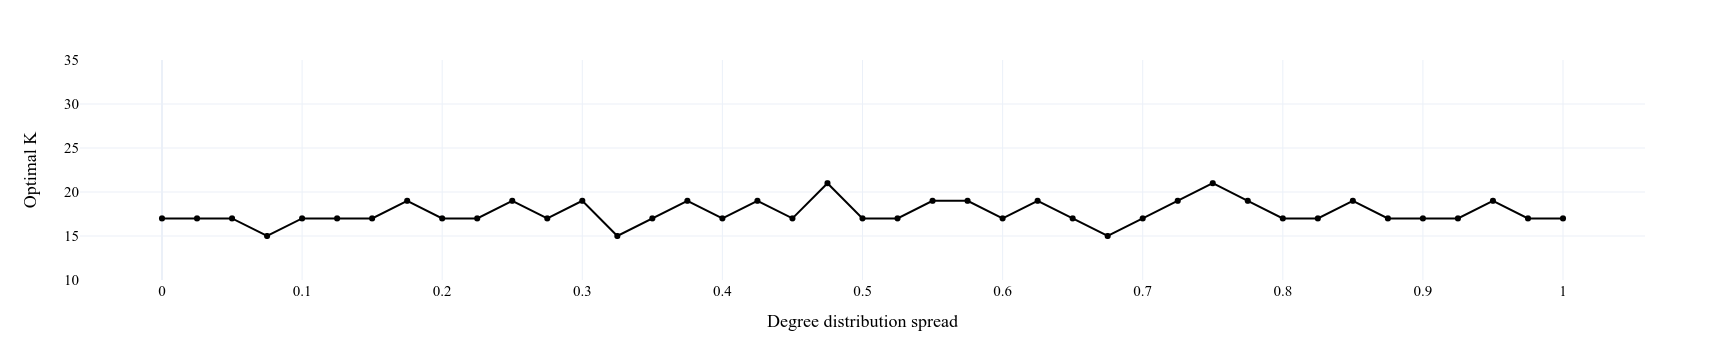

In [25]:
optimal_k_df["color"] = "black"
fig = px.line(
    optimal_k_df, x='spread', y='ELO_Rating_K', color="color",
    color_discrete_map={"black": "black"},
    markers=True,
    labels={
        "ELO_Rating_K": "K"
    },
)
return_fig_settings(fig, "Degree distribution spread", "Optimal K")
fig.update_yaxes(range=[10, 35])
fig.update_xaxes(tickmode='linear', tick0=0, dtick=0.1)
fig.update_layout(showlegend=False)
fig.show(config=config)

What about optimal K for each degree group?

In [26]:
home_df = in_sample[['spread', 'HomeTeam', 'Round', 'ELO_Rating_K', "HomeDegreeGroup", "HomeDiff", "RPS"]].rename(columns={
    "HomeDegreeGroup": "TeamDegreeGroup", "HomeDiff": "team_diff", "HomeTeam": "Team"
}).reset_index()
away_df = in_sample[['spread', 'AwayTeam', 'Round', 'ELO_Rating_K', "AwayDegreeGroup", "AwayDiff", "RPS"]].rename(columns={
    "AwayDegreeGroup": "TeamDegreeGroup", "AwayDiff": "team_diff", "AwayTeam": "Team"
}).reset_index()
team_df = pd.concat([home_df, away_df])
team_df.head()

index  spread  Team  Round  ELO_Rating_K TeamDegreeGroup  team_diff    RPS
0   4867  0.0000   180     80             5    medium_group   116.3502 0.2110
1   4868  0.0000    37     80             5    medium_group   111.4846 0.2477
2   4869  0.0000    41     80             5      low_degree    55.3767 0.3451
3   4870  0.0000    36     80             5    medium_group    39.6431 0.2038
4   4871  0.0000    35     80             5      low_degree    21.5221 0.1575

In [27]:
optimizer = 'RPS'
in_sample_agg_by_degree = team_df.groupby(['spread', 'ELO_Rating_K', "TeamDegreeGroup"], as_index=False).agg({'RPS': 'mean', 'team_diff': 'mean'})
optimal_k_by_degree = in_sample_agg_by_degree[in_sample_agg_by_degree.groupby(['spread', "TeamDegreeGroup"])[optimizer].transform(min) == in_sample_agg_by_degree[optimizer]]
optimal_k_by_degree.head()

spread  ELO_Rating_K TeamDegreeGroup    RPS  team_diff
17  0.0000            15     high_degree 0.2049    35.6569
19  0.0000            17    medium_group 0.2052    30.6491
24  0.0000            21      low_degree 0.2006    35.0019
78  0.0250            15      low_degree 0.2102    32.3584
80  0.0250            15     high_degree 0.2050    25.9631

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



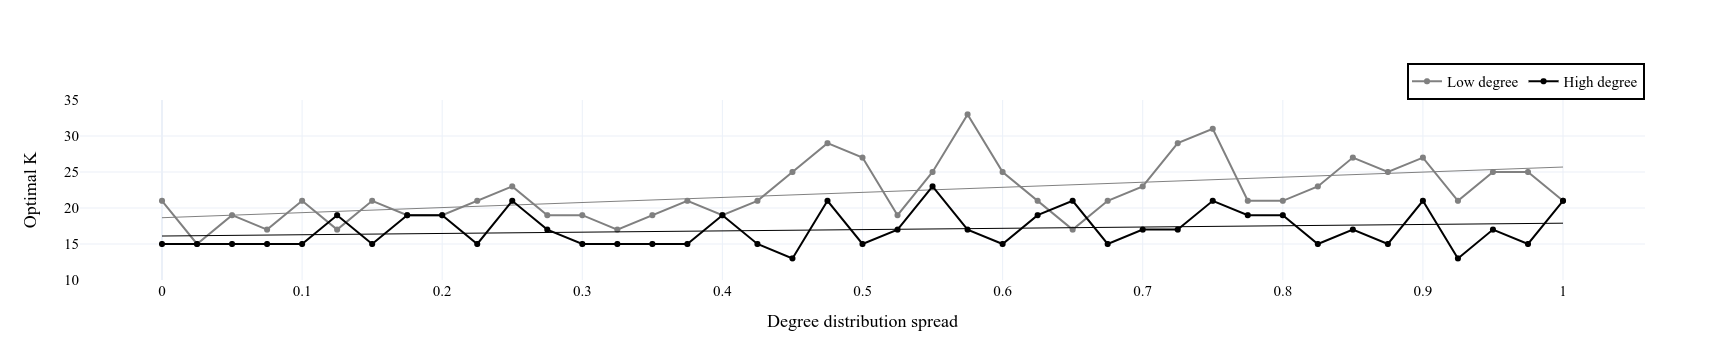

In [28]:
fig = go.Figure()
target = "ELO_Rating_K"
for name, g_name, color in [("low_degree", "Low degree", "gray"), ("high_degree", "High degree", "black")]:
    df = optimal_k_by_degree[optimal_k_by_degree["TeamDegreeGroup"] == name]
    df['bestfit'] = sm.OLS(df[target], sm.add_constant(df['spread'])).fit().fittedvalues
    fig.add_traces([
        go.Scatter(
            x=df["spread"],
            y=df[target],
            mode='lines+markers',
            name=g_name,
            legendgroup=g_name,
            line={
                "color": f"{color}",
                "width": 2
            }
        ),
        go.Scatter(
            x=df["spread"],
            y=df['bestfit'],
            mode='lines',
            name=g_name,
            legendgroup=g_name,
            showlegend=False,
            line={
                "color": f"{color}",
                "width": 1
            }
        ),
    ])
return_fig_settings(fig, "Degree distribution spread", "Optimal K")
fig.update_layout(showlegend=True)
fig.update_yaxes(range=[10, 35])
fig.update_xaxes(tickmode='linear', tick0=0, dtick=0.1)
fig.show(config=config)

In [29]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'summary_with_mean',
        "height": 800,
        "width": 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis2_title=x_title,
        yaxis1_title=y_title,
        yaxis2_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=14,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=1,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    font_dict = dict(
        family='Times New Roman',
        size=14,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



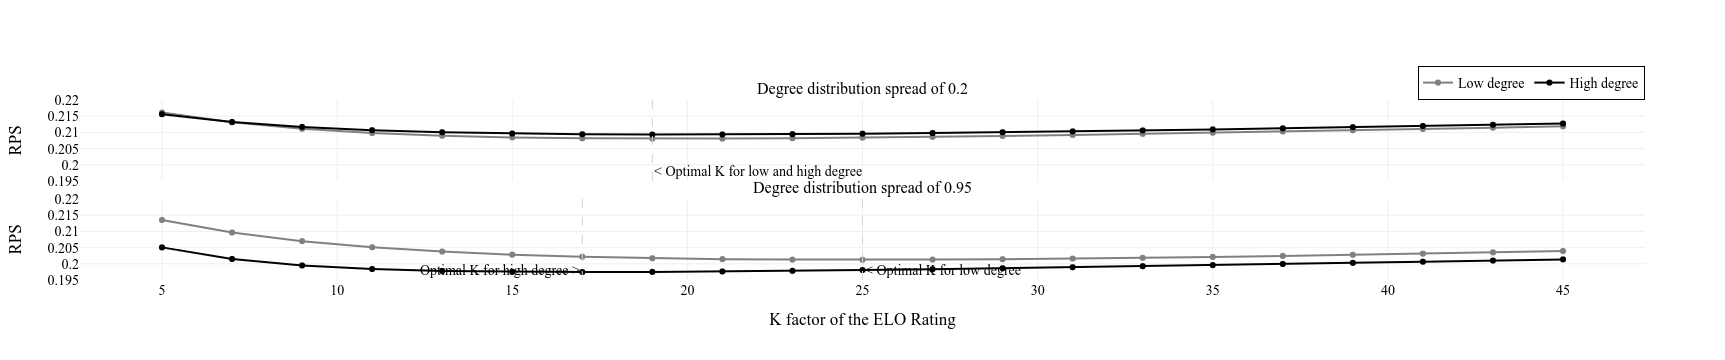

In [30]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    vertical_spacing=0.1,
    subplot_titles=("Degree distribution spread of 0.2","Degree distribution spread of 0.95")
)
variance = 0.95
target = "RPS"
df = in_sample_agg_by_degree[in_sample_agg_by_degree.spread == variance].groupby(["ELO_Rating_K", "TeamDegreeGroup"], as_index=False).agg({"RPS": "mean"})
for name, g_name, color in [("low_degree", "Low degree", "gray"), ("high_degree","High degree", "black")]:
    plot_df = df[df.TeamDegreeGroup == name]
    plot_df['bestfit'] = sm.OLS(plot_df[target], sm.add_constant(plot_df['ELO_Rating_K'])).fit().fittedvalues
    fig.add_trace(
        go.Scatter(
            x=plot_df["ELO_Rating_K"],
            y=plot_df[target],
            mode='lines+markers',
            name=g_name,
            legendgroup=g_name,
            line={
                "color": f"{color}",
                "width": 2
            },
        ),
        row=2,col=1
    )
variance = 0.2
df = in_sample_agg_by_degree[in_sample_agg_by_degree.spread == variance].groupby(["ELO_Rating_K", "TeamDegreeGroup"], as_index=False).agg({"RPS": "mean"})
for name, g_name, color in [("low_degree", "Low degree", "gray"), ("high_degree","High degree", "black")]:
    plot_df = df[df.TeamDegreeGroup == name]
    plot_df['bestfit'] = sm.OLS(plot_df[target], sm.add_constant(plot_df['ELO_Rating_K'])).fit().fittedvalues
    fig.add_trace(
        go.Scatter(
            x=plot_df["ELO_Rating_K"],
            y=plot_df[target],
            mode='lines+markers',
            name=g_name,
            legendgroup=g_name,
            showlegend=False,
            line={
                "color": f"{color}",
                "width": 2
            }
        ),
        row=1,col=1
    )
return_fig_settings(fig, "K factor of the ELO Rating", target)
fig.update_layout(showlegend=True)
fig.update_yaxes(range=[0.195, 0.22])
fig.add_vline(x=17, line_width=1, line_dash="dash", line_color="lightgray", annotation_text="Optimal K for high degree >", annotation_position="bottom left", row=2, col=1)
fig.add_vline(x=25, line_width=1, line_dash="dash", line_color="lightgray", annotation_text="< Optimal K for low degree", annotation_position="bottom right", row=2, col=1)
fig.add_vline(x=19, line_width=1, line_dash="dash", line_color="lightgray", annotation_text="< Optimal K for low and high degree", annotation_position="bottom right", row=1, col=1)
fig.show(config=config)

In [176]:
df_optimal = experiment_df.merge(optimal_k_df, on=['spread', 'ELO_Rating_K'], how='inner', suffixes=["", "_IS"])
df_optimal = df_optimal[df_optimal.Round > df_optimal.Split_Rounds]

In [177]:
df_optimal[df_optimal.Variance == 0][["spread", "HomeDegree", "HomeDegreeGroup", "HomeDiff", "AwayDegree", "AwayDegreeGroup", "AwayDiff", "TeamDiff"]]

spread  HomeDegree HomeDegreeGroup  HomeDiff  AwayDegree  \
12023  0.0000         274     high_degree    4.3256         238   
12024  0.0000         254    medium_group   15.0817         228   
12025  0.0000         250    medium_group   11.5394         246   
12026  0.0000         234    medium_group   30.3106         230   
12027  0.0000         244    medium_group    1.7290         244   
...       ...         ...             ...       ...         ...   
24041  0.0000         254    medium_group   37.5463         232   
24042  0.0000         232    medium_group   54.0514         240   
24043  0.0000         228    medium_group    8.6102         246   
24044  0.0000         222      low_degree   57.9267         226   
24045  0.0000         216      low_degree   33.4498         214   

      AwayDegreeGroup  AwayDiff  TeamDiff  
12023    medium_group   26.2197   15.2726  
12024    medium_group   35.5549   25.3183  
12025    medium_group   17.5274   14.5334  
12026    medium_group   26.6414   28.4760  
12027    medium_group   33.7810   17.7550  
...               ...       ...       ...  
24041    medium_group   17.0414   27.2939  
24042    medium_group    8.7410   31.3962  
24043    medium_group   48.8886   28.7494  
24044    medium_group   16.0524   36.9896  
24045      low_degree   55.8877   44.6687  

[12023 rows x 8 columns]

In [179]:
home_team_results = df_optimal.groupby(['spread', 'ELO_Rating_K', "HomeDegreeGroup"]).agg(team_diff=("HomeDiff", np.mean)).reset_index().dropna().rename(columns={"HomeDegreeGroup": "TeamDegreeGroup"})
away_team_results = df_optimal.groupby(['spread', 'ELO_Rating_K', "AwayDegreeGroup"]).agg(team_diff=("AwayDiff", np.mean)).reset_index().dropna().rename(columns={"AwayDegreeGroup": "TeamDegreeGroup"})
team_results = pd.concat([home_team_results, away_team_results]).groupby(['spread', "TeamDegreeGroup"], as_index=False).agg(team_diff=("team_diff", np.mean), ELO_Rating_K=("ELO_Rating_K", "first"))
team_results[team_results.spread == 0.7]


spread TeamDegreeGroup  team_diff  ELO_Rating_K
84  0.7000      low_degree    37.8588            17
85  0.7000    medium_group    28.8322            17
86  0.7000     high_degree    29.4940            17

In [180]:
team_results_all = pd.concat([home_team_results, away_team_results]).groupby(['spread'], as_index=False).agg(team_diff=("team_diff", np.mean), ELO_Rating_K=("ELO_Rating_K", "first"))

In [181]:
test_df = experiment_df.groupby(['spread', 'Round']).agg({'HomeRating': ['mean', 'std']})
test_df.loc[0.7]

HomeRating         
            mean      std
Round                    
0       987.7647  99.3793
1      1003.1384  92.3414
2       988.5223  98.1958
3      1014.1594  98.0647
4       997.5103 101.4397
...          ...      ...
393    1006.9100  96.6750
394     995.9120 107.1182
395    1018.0023  98.9986
396     983.1583 108.7707
397    1013.6026 102.5369

[398 rows x 2 columns]

In [182]:
result_df = df_optimal.groupby(['spread', 'ELO_Rating_K'],dropna=True).agg(
    {'RPS': np.mean, 'Likelihood': np.mean, 'ForecastError': np.mean, 'ExpectedRPS': np.mean, 'Forecastability': np.mean,'RatingError': np.mean, 'TotalDiff': np.mean, "TeamDiff": np.mean}
)
result_df = result_df.reset_index().dropna()
result_df[result_df.spread == 0.7]

spread  ELO_Rating_K    RPS  Likelihood  ForecastError  ExpectedRPS  \
28  0.7000            17 0.2042     -0.9991         0.0042       0.2038   

    Forecastability  RatingError  TotalDiff  TeamDiff  
28           0.1996      38.4061    59.7124   29.8562

In [183]:
result_df_with_quantiles = df_optimal.groupby(['spread', 'ELO_Rating_K', "TotalDegreeGroup"],dropna=True).agg(
    {'HomeTeam': 'count', 'RPS': np.mean, 'Likelihood': np.mean, 'ForecastError': np.mean, 'ExpectedRPS': np.mean, 'Forecastability': np.mean,'RatingError': np.mean, 'TotalDiff': np.mean, "TeamDiff": np.mean}
)
result_df_with_quantiles = result_df_with_quantiles.reset_index().dropna()
result_df_with_quantiles[result_df_with_quantiles.spread == 0.7]

spread  ELO_Rating_K TotalDegreeGroup  HomeTeam    RPS  Likelihood  \
339  0.7000            17       low_degree      1131 0.2145     -1.0312   
340  0.7000            17     medium_group      8995 0.2029     -0.9948   
341  0.7000            17      high_degree      1008 0.2048     -1.0013   

     ForecastError  ExpectedRPS  Forecastability  RatingError  TotalDiff  \
339         0.0062       0.2076           0.2014      45.6945    69.8043   
340         0.0039       0.2042           0.2003      37.3463    58.3961   
341         0.0042       0.1956           0.1915      39.6854    60.1347   

     TeamDiff  
339   34.9021  
340   29.1981  
341   30.0673

In [64]:
df_optimal[(df_optimal.spread == 156) & (df_optimal.TotalDegreeGroup == "high_degree")]

Unnamed: 0  HomeTeam  AwayTeam  Season  Round     Day Result  \
595483     2316589        36       136       0    199   89949   away   
595509     2316615        76       176       0    199   89949   away   
595535     2316641       126        24       0    200   90401   away   
595543     2316649       138        36       0    200   90401   away   
595544     2316650       139        37       0    200   90401   draw   
...            ...       ...       ...     ...    ...     ...    ...   
606587     2327693        24       122       0    397  179445   home   
606606     2327712        50       148       0    397  179445   draw   
606610     2327716        59       157       0    397  179445   home   
606619     2327725        77       175       0    397  179445   home   
606631     2327737       199       198       0    397  179445   home   

          TrueForecast CalculatedForecast  ELO_Rating_K  Variance  Density  \
595483  0.18-0.24-0.58     0.17-0.24-0.59            17       156   0.5668   
595509  0.28-0.28-0.43     0.46-0.28-0.26            17       156   0.5668   
595535  0.07-0.13-0.79     0.08-0.15-0.77            17       156   0.5668   
595543  0.58-0.24-0.18     0.55-0.25-0.20            17       156   0.5668   
595544  0.46-0.28-0.26     0.38-0.29-0.33            17       156   0.5668   
...                ...                ...           ...       ...      ...   
606587  0.47-0.28-0.25     0.42-0.29-0.29            17       156   0.5668   
606606  0.25-0.28-0.48     0.30-0.29-0.41            17       156   0.5668   
606610  0.72-0.17-0.10     0.69-0.19-0.12            17       156   0.5668   
606619  0.78-0.14-0.08     0.80-0.13-0.07            17       156   0.5668   
606631  0.47-0.28-0.26     0.42-0.29-0.29            17       156   0.5668   

        RealDegree  RealVariance    RPS  Likelihood  ForecastError  \
595483    224.4623       98.6762 0.0983     -0.5253         0.0001   
595509    224.4623       98.6762 0.3784     -1.3417         0.0310   
595535    224.4623       98.6762 0.0293     -0.2588         0.0003   
595543    224.4623       98.6762 0.4763     -1.6308         0.0006   
595544    224.4623       98.6762 0.1264     -1.2360         0.0062   
...            ...           ...    ...         ...            ...   
606587    224.4623       98.6762 0.2076     -0.8567         0.0021   
606606    224.4623       98.6762 0.1298     -1.2460         0.0035   
606610    224.4623       98.6762 0.0561     -0.3749         0.0008   
606619    224.4623       98.6762 0.0222     -0.2219         0.0002   
606631    224.4623       98.6762 0.2100     -0.8636         0.0016   

        ExpectedRPS  Forecastability  HomeRating  AwayRating  Home_elo_ratin  \
595483       0.1949           0.1948    899.7867   1104.7385             nan   
595509       0.2549           0.2240   1021.7072   1128.0289             nan   
595535       0.1154           0.1151    751.6306   1127.0410             nan   
595543       0.1952           0.1946   1004.9723    899.3643             nan   
595544       0.2263           0.2201   1026.9041   1000.9396             nan   
...             ...              ...         ...         ...             ...   
606587       0.2205           0.2184   1126.3260   1093.0752             nan   
606606       0.2219           0.2183    832.4990    966.0656             nan   
606610       0.1468           0.1460   1099.8744    888.9105             nan   
606619       0.1216           0.1214   1141.3800    879.4174             nan   
606631       0.2214           0.2197   1065.5527   1038.0121             nan   

        Away_elo_ratin  Home_elo_rating  Away_elo_rating  spread  TrueDiff  \
595483             nan         911.3517        1122.9549  0.6500 -204.9518   
595509             nan        1058.3437        1035.2355  0.6500 -106.3217   
595535             nan         793.5227        1146.7487  0.6500 -375.4104   
595543             nan         991.4036         905.9257  0.6500  105.6080   
595544        

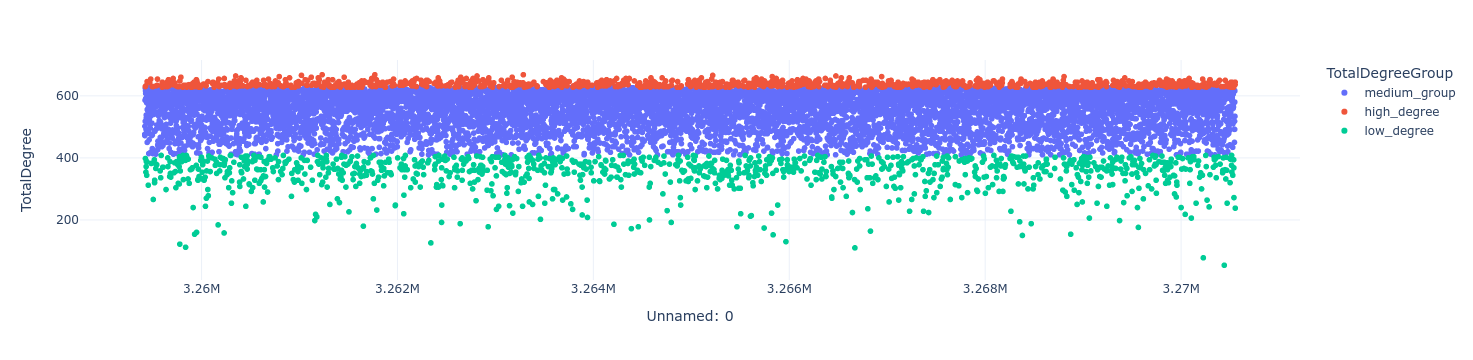

In [184]:
plot_df = df_optimal[df_optimal.spread == 0.7]
fig = px.scatter(
    plot_df,
    x="Unnamed: 0",
    y="TotalDegree",
    color="TotalDegreeGroup"
)

fig.show()

### Analysis Out of Sample

In [214]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'figure',
        "height": 400,
        "width": 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=15,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=2,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    font_dict = dict(
        family='Times New Roman',
        size=15,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

#### RPS based metrics

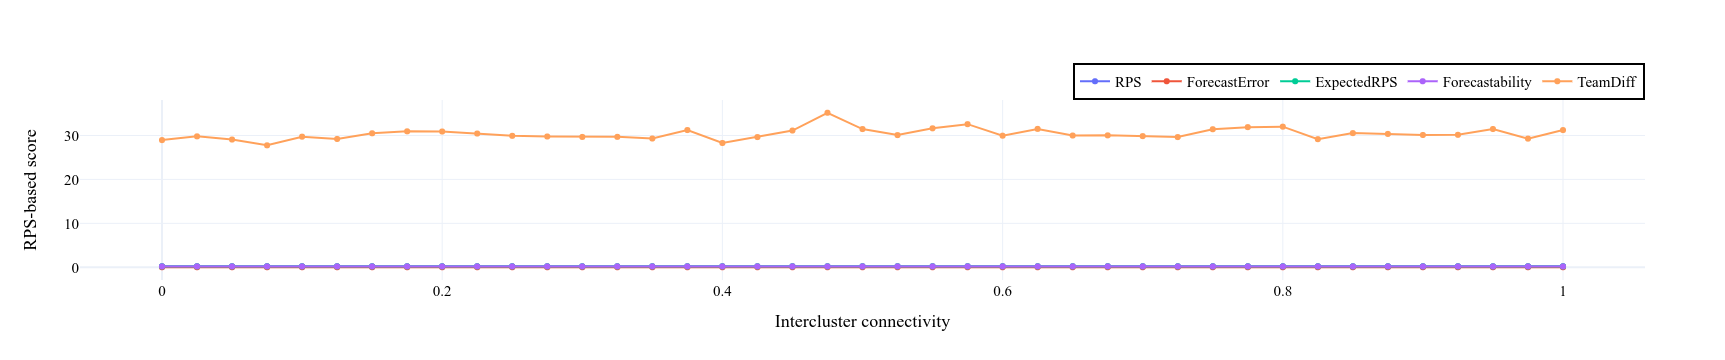

In [191]:
result_df["color"] = "black"
fig = go.Figure()
for rps_based_metric in ["RPS", "ForecastError", "ExpectedRPS", "Forecastability", "TeamDiff"]:
    fig.add_trace(
        go.Scatter(
            y=result_df[rps_based_metric],
            x=result_df["spread"],
            mode="lines+markers",
            name=rps_based_metric
        )
    )
return_fig_settings(fig, "Intercluster connectivity", "RPS-based score")
fig.update_layout(showlegend=True)
fig.show(config=config)

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



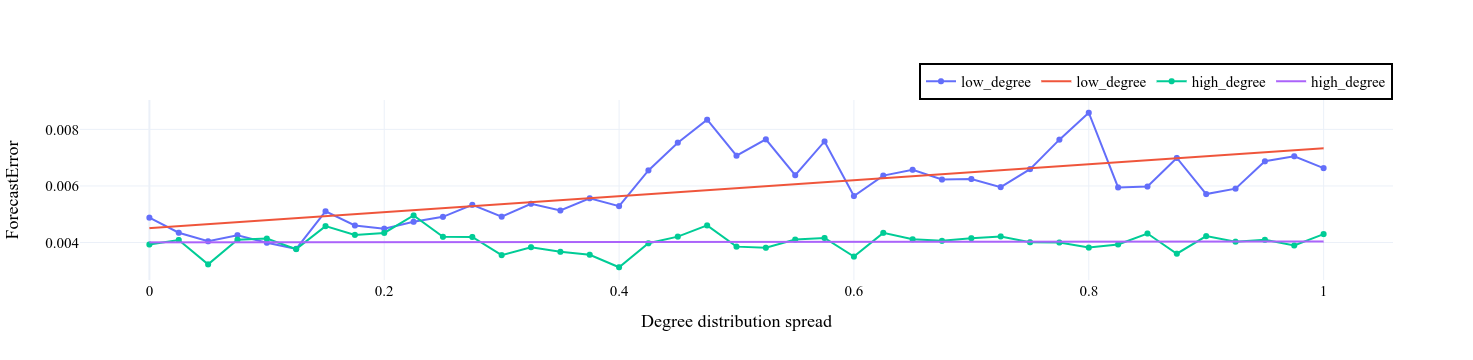

In [187]:
fig = go.Figure()
target = "ForecastError"
for name in ["low_degree", "high_degree"]:
    df = result_df_with_quantiles[result_df_with_quantiles["TotalDegreeGroup"] == name]
    df['bestfit'] = sm.OLS(df[target], sm.add_constant(df['spread'])).fit().fittedvalues
    fig.add_traces([
        go.Scatter(
            x=df["spread"],
            y=df[target],
            mode='lines+markers',
            name=name
        ),
        go.Scatter(
            x=df["spread"],
            y=df['bestfit'],
            mode='lines',
            name=name
        ),
    ])
return_fig_settings(fig, "Degree distribution spread", target)
fig.update_layout(showlegend=True)
fig.show(config=config)

#### Team level analysis

In [212]:
team_results

spread TeamDegreeGroup  team_diff  ELO_Rating_K
0    0.0000      low_degree    30.4625            17
1    0.0000    medium_group    28.9566            17
2    0.0000     high_degree    25.5165            17
3    0.0250      low_degree    28.7006            17
4    0.0250    medium_group    29.9029            17
..      ...             ...        ...           ...
118  0.9750    medium_group    27.2012            17
119  0.9750     high_degree    34.0073            17
120  1.0000      low_degree    35.8797            17
121  1.0000    medium_group    30.5227            17
122  1.0000     high_degree    32.3888            17

[123 rows x 4 columns]

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



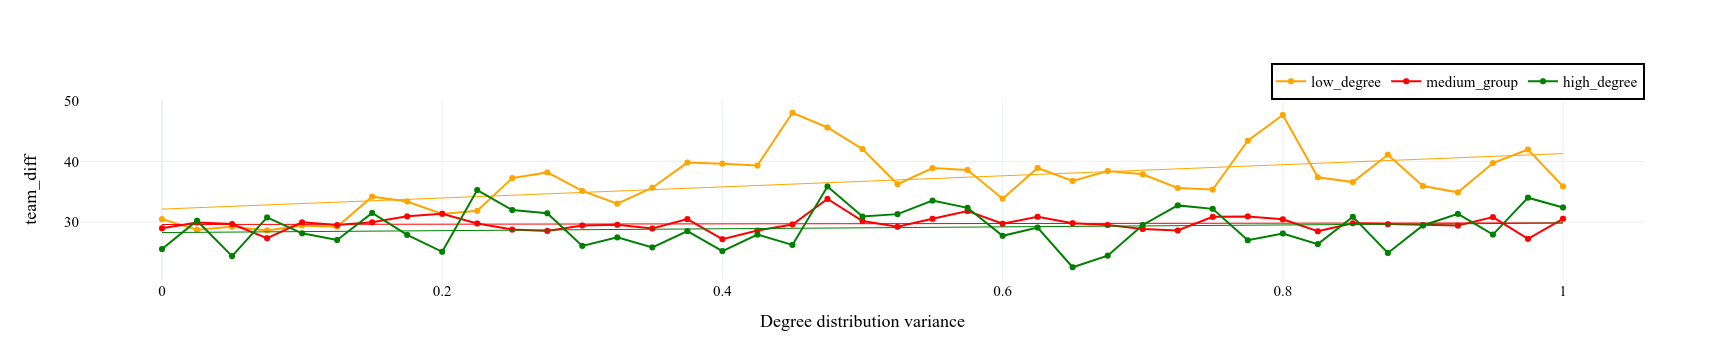

In [215]:
fig = go.Figure()
target = "team_diff"
for name, color in [("low_degree", "orange"), ("medium_group", "red"), ("high_degree", "green")]:
    df = team_results[team_results["TeamDegreeGroup"] == name]
    df['bestfit'] = sm.OLS(df[target], sm.add_constant(df['spread'])).fit().fittedvalues
    fig.add_traces([
        go.Scatter(
            x=df["spread"],
            y=df[target],
            mode='lines+markers',
            legendgroup=name,
            name=name,
            line={
                "color": f"{color}",
                "width": 2
            }
        ),
        go.Scatter(
            x=df["spread"],
            y=df['bestfit'],
            mode='lines',
            legendgroup=name,
            name=name + "bestfit",
            showlegend=False,
            line={
                "color": f"{color}",
                "width": 1
            }
        )
    ])
return_fig_settings(fig, "Degree distribution variance", target)
#fig.update_yaxes(range=[0.165, 0.225])
fig.update_layout(showlegend=True)
fig.show(config=config)

In [207]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'figure',
        'height': 800,
        'width': 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis3_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=14,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=1,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        ),
        yaxis3_range=[0.18, 0.22],
        yaxis2_range=[0.0020, 0.0060],
        yaxis1_range=[20, 40],        
        yaxis3_title="RPS",
        yaxis2_title="Forecast error",
        yaxis1_title="Rating error",
    )
    font_dict = dict(
        family='Times New Roman',
        size=14,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

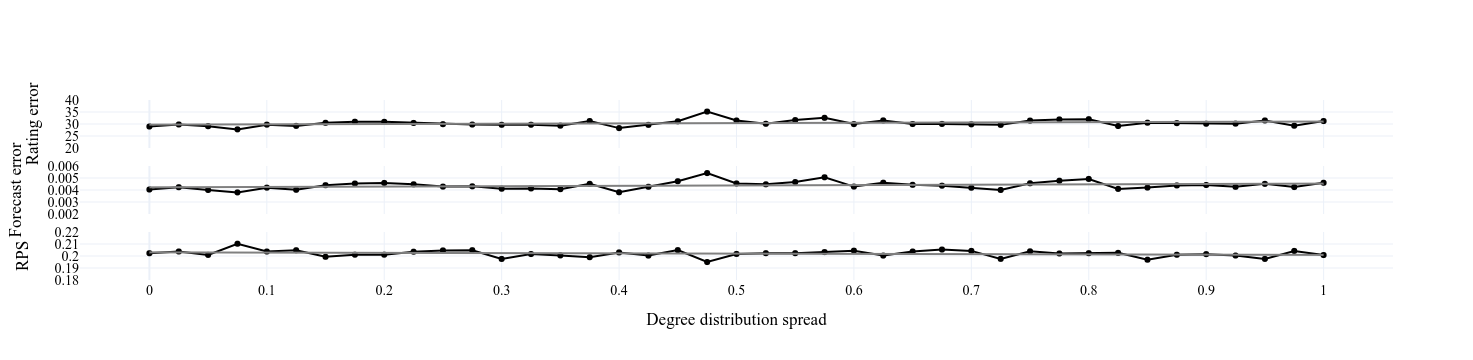

In [208]:
from plotly.subplots import make_subplots

target_1 = "ForecastError"
target_2 = "TeamDiff"
target_3 = "RPS"
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1)
for i, (t, t_name) in enumerate([("RPS", "RPS"), ("ForecastError", "Forecast error"), ("TeamDiff", "Rating error")]):
    fig.add_trace(
        go.Scatter(
            y=result_df[t],
            x=result_df["spread"],
            marker_color="black",
            mode="lines+markers",
            showlegend=False
        ),
        row=3 - i,
        col=1
    )
    result_df['bestfit' + t] = sm.OLS(result_df[t], sm.add_constant(result_df['spread'])).fit().fittedvalues
    fig.add_trace(
        go.Scatter(
            x=result_df["spread"],
            y=result_df['bestfit' + t],
            mode='lines',
            marker_color="gray",
            showlegend=False
        ),
        row=3-i, col=1
    )
return_fig_settings(fig, "Degree distribution spread", "")
fig.update_xaxes(tickmode='linear', tick0=0.0, dtick=0.1)
#fig.update_layout(showlegend=False)
fig.show(config=config)

In [239]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'figure',
        'height': 800,
        'width': 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis3_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=14,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=1,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        ),
        yaxis3_range=[0.16, 0.24],
        yaxis2_range=[0.0020, 0.0090],
        yaxis1_range=[20, 50],        
        yaxis3_title="RPS",
        yaxis2_title="Forecast error",
        yaxis1_title="Rating error",
    )
    font_dict = dict(
        family='Times New Roman',
        size=14,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



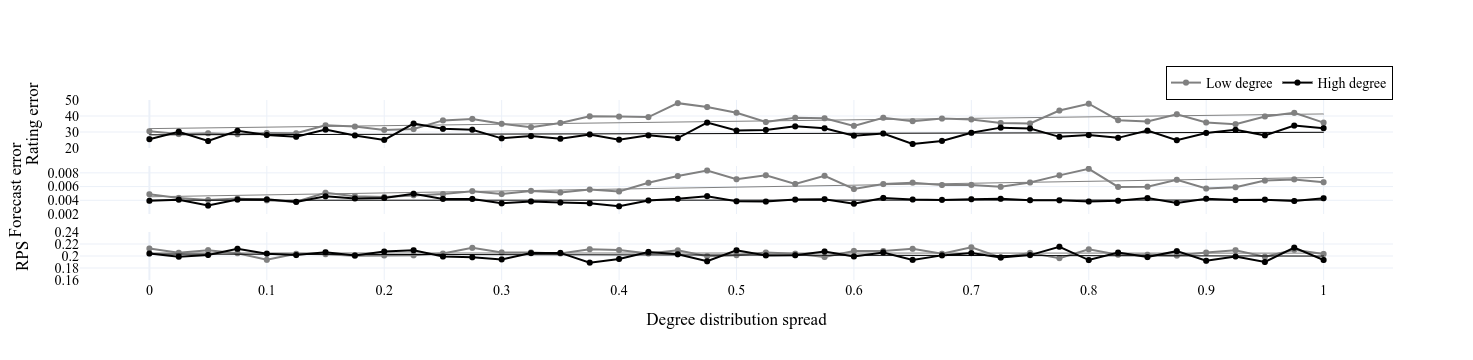

In [241]:
from plotly.subplots import make_subplots

first_group = True
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1)
for i, (t, t_name, variable_df, variable) in enumerate([
    ("RPS", "RPS", result_df_with_quantiles, "TotalDegreeGroup"), 
    ("ForecastError", "Forecast error", result_df_with_quantiles, "TotalDegreeGroup"), 
    ("team_diff", "Rating error", team_results, "TeamDegreeGroup")
]):
    i_row = 3 - i
    col = 1
    for name, g_name, color in [("low_degree", "Low degree", "gray"), ("high_degree", "High degree", "black")]:
        df = variable_df[variable_df[variable] == name]
        df['bestfit'] = sm.OLS(df[t], sm.add_constant(df['spread'])).fit().fittedvalues
        fig.add_trace(
            go.Scatter(
                x=df["spread"],
                y=df[t],
                mode='lines+markers',
                legendgroup=g_name,
                showlegend=first_group,
                name=g_name,
                line={
                    "color": f"{color}",
                    "width": 2
                }
            ), row=i_row, col=col
        )
        fig.add_trace(
            go.Scatter(
                x=df["spread"],
                y=df['bestfit'],
                mode='lines',
                legendgroup=g_name,
                name=g_name + "bestfit",
                showlegend=False,
                line={
                    "color": f"{color}",
                    "width": 1
                }
            ), row=i_row, col=col
        )
    first_group = False
return_fig_settings(fig, "Degree distribution spread", "")
fig.update_xaxes(tickmode='linear', tick0=0.0, dtick=0.1)
#fig.update_layout(showlegend=False)
fig.show(config=config)

Team diff for all degrees

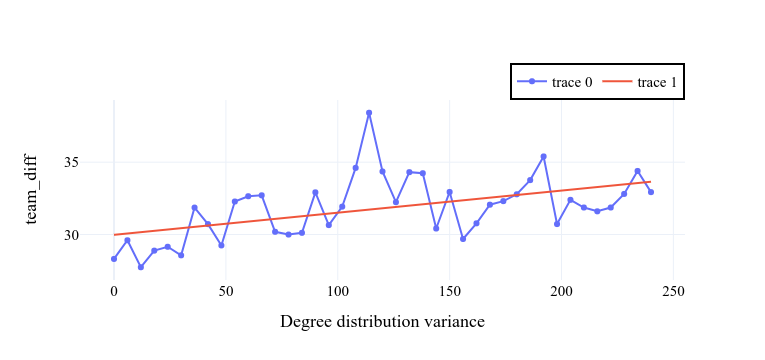

In [70]:
fig = go.Figure()
target= "team_diff"
team_results_all['bestfit'] = sm.OLS(team_results_all[target], sm.add_constant(team_results_all['Variance'])).fit().fittedvalues
fig.add_traces([
    go.Scatter(
        x=team_results_all["Variance"],
        y=team_results_all[target],
        mode='lines+markers',
    ),
    go.Scatter(
        x=team_results_all["Variance"],
        y=team_results_all['bestfit'],
        mode='lines',
    )
])
return_fig_settings(fig, "Degree distribution variance", target)
#fig.update_yaxes(range=[0.165, 0.225])
fig.update_layout(showlegend=True)
fig.show(config=config)

### Bar plots with confidence intervals

In [ ]:
x = result_df['Variance']
y_upper = [t[1] for t in result_df["RPS_bootstrap"]]
y_lower = [t[0] for t in result_df[("RPS_bootstrap")]]

fig = go.Figure([
    go.Scatter(
        x=x,
        y=result_df["RPS_mean"],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=pd.concat([x,x[::-1]]), # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])
fig.update_yaxes(range=[0.15, 0.25])
fig.show()

In [ ]:
x = result_df['Variance']
y_upper = [t[1] for t in result_df["RatingError_bootstrap"]]
y_lower = [t[0] for t in result_df[("RatingError_bootstrap")]]

fig = go.Figure([
    go.Scatter(
        x=x,
        y=result_df["RatingError_mean"],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=pd.concat([x,x[::-1]]), # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])

fig.update_yaxes(range=[0, 400])
fig.show()

In [ ]:
x = result_df['Variance']
y_upper = [t[1] for t in result_df["TotalDiff_bootstrap"]]
y_lower = [t[0] for t in result_df[("TotalDiff_bootstrap")]]

fig = go.Figure([
    go.Scatter(
        x=x,
        y=result_df["TotalDiff_mean"],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=pd.concat([x,x[::-1]]), # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])
fig.update_yaxes(range=[0, 200])
fig.show()